In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Define the ticker symbol for Apple
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", )
data.columns = data.columns.get_level_values(0)
print(data.shape)

[*********************100%***********************]  1 of 1 completed

(1236, 6)


### Compute weights

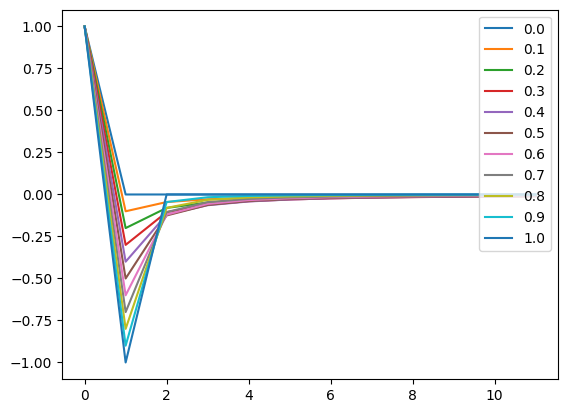

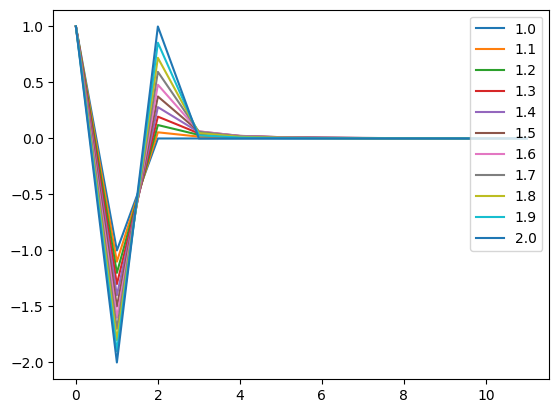

In [3]:
def getWeights(d, size):
    # thres > 0 drops insignificant weights
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1]/k * (d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w

def plotWeights(dRange, nPlots, size):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        d = d.round(1)
        w_ = getWeights(d, size=size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot()
    ax.legend(fontsize=10, loc='upper right')
    plt.show()
    return

#----------------------------------------
if __name__ == '__main__':
    plotWeights(dRange=[0,1], nPlots=11, size=12)
    plotWeights(dRange=[1,2], nPlots=11, size=12)

### Standard FracDiff (Expanding Window)

In [4]:
def fracDiff(series, d, thres=.01):
    '''
    Increase width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily bounded [0,1]
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].ffill().dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue #exclude NAs
            df_[loc] = np.dot(w[-(iloc+1):, :].T, seriesF.loc[:loc])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [30]:
data_log = data.apply(np.log)

In [31]:
data_frac = fracDiff(data_log, d=.4, thres=.05)
data_frac.shape

(1182, 6)

In [33]:
def two_in_1(frac_df, df, figsize=(12, 6)):
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=figsize)
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('FracDiff Close', color=color)
    ax1.plot(frac_df, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Close', color=color)  # we already handled the x-label with ax1
    ax2.plot(df, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

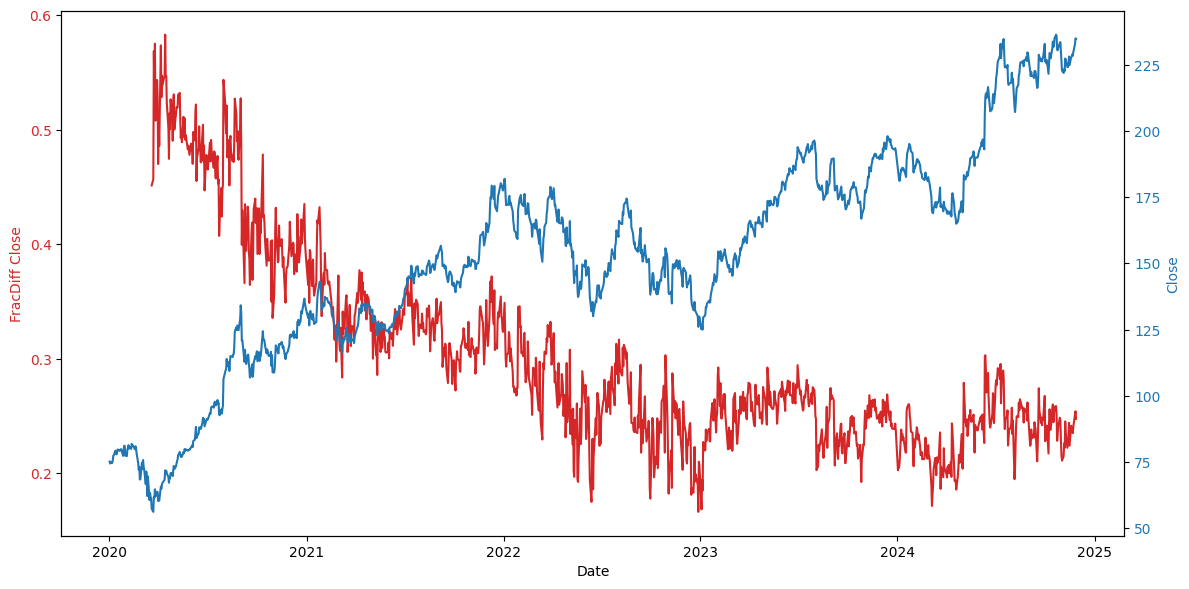

In [34]:
two_in_1(data_frac['Close'], data['Close'])

### Fixed-Width Window Fracdiff

In [35]:
def getWeights_FFD(d, thres=1e-5):
    w=[1.]
    if thres <= 0:
        print("Threshold must be positive, set to 1e-5")
        thres = 1e-5
    k = 1
    while abs(w[-1]) >= thres:
        w_ = -w[-1]/k*(d-k+1) 
        k += 1
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


In [9]:
def fracDiff_FFD(series, d, thres=1e-5):
    w = getWeights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        seriesF, df_ = series[[name]].ffill().dropna(), pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc1 - width], seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue # exclude NAs
            df_[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [36]:
data_frac_FFD = fracDiff_FFD(data_log, d=0.4, thres=0.0001)
data_frac_FFD.shape

(954, 6)

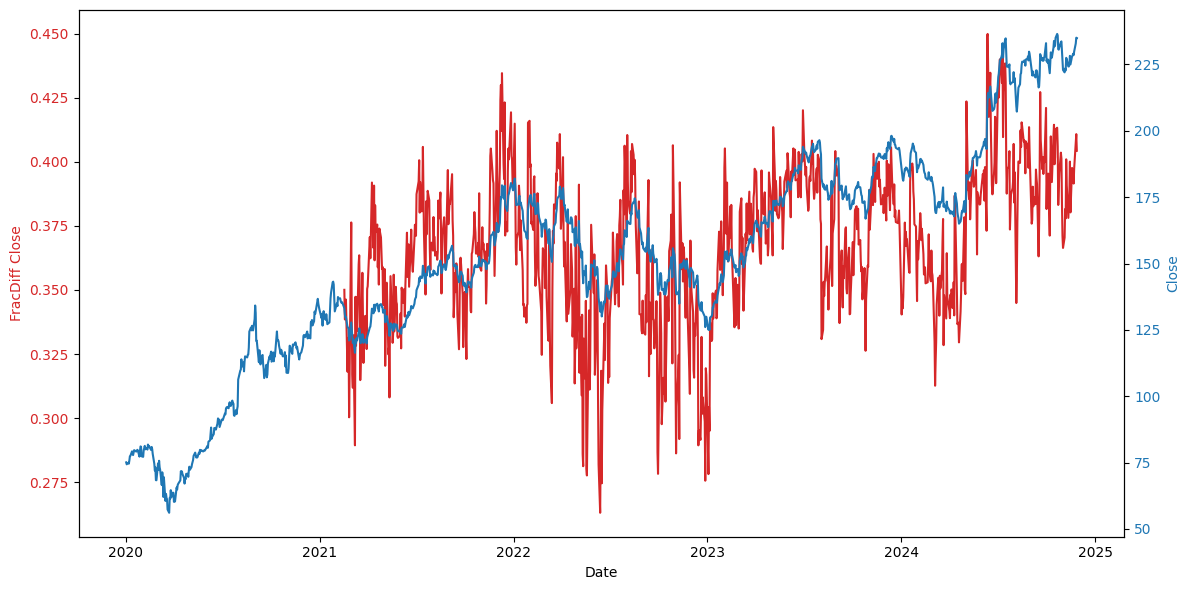

In [38]:
two_in_1(data_frac_FFD['Close'], data['Close'])

### Test the correlation

In [40]:
from statsmodels.tsa.stattools import adfuller
adfuller(data_frac_FFD['Close'], maxlag=1, regression='c', autolag=None)

(np.float64(-7.912004550817311),
 np.float64(3.925294052738789e-12),
 1,
 952,
 {'1%': np.float64(-3.437237626048241),
  '5%': np.float64(-2.8645807475403657),
  '10%': np.float64(-2.56838906578808)})

### Finding the minimal d that passes the adf test

In [41]:
def plotMinFFD(df):
    from statsmodels.tsa.stattools import adfuller
    out = pd.DataFrame(columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = df.copy()
    for d in np.linspace(0,1,11):
        df1 = np.log(df0[['Close']]).resample('1D').last()
        df2 = fracDiff_FFD(df1, d, thres=0.01)
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0,1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4])+[df2[4]['5%']] + [corr]
    
    out[['adfStat', 'corr']].plot(secondary_y='adfStat', figsize=(12,6))
    plt.axhline(out['95% conf'].mean(), linewidth=1, color='r', linestyle='dotted')
    return

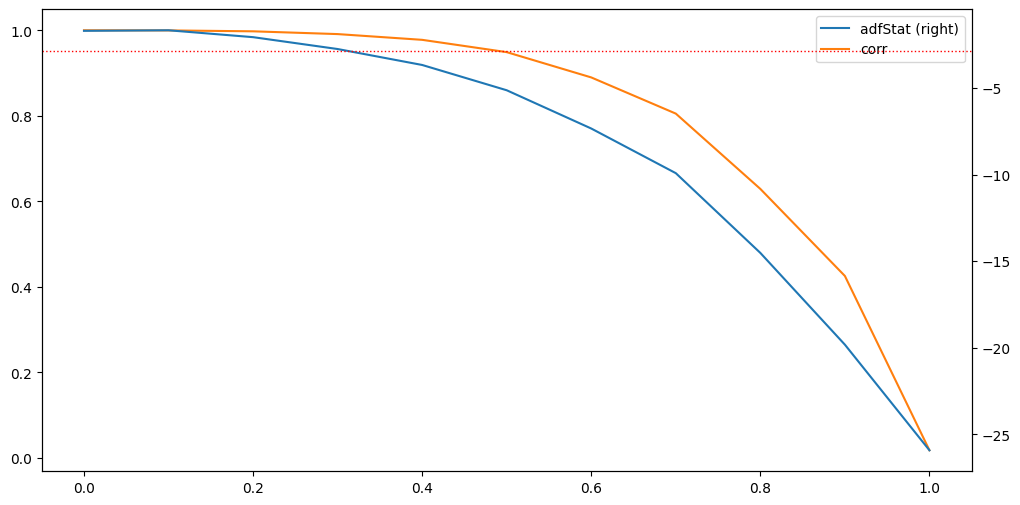

In [42]:
plotMinFFD(data)

## Exercise

5.1 Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series:
1. Compute the ADF statistic on this series. What is the p-value?
2. Compute the cumulative sum of the observations. This is a non-stationary series without memory.
    - What is the order of integration of this cumulative series?
    - Compute the ADF statistic on this series. What is the p-value?
3. Differentiate the series twice. What is the p-value of this over-differentiated series?

Generate a time series from an IID Gaussian random process

In [46]:
n = 1000  # Number of samples
mu = 0   # Mean of the Gaussian distribution
sigma = 1  # Standard deviation of the Gaussian distribution

# Generate IID Gaussian random process
time_series = np.random.normal(mu, sigma, n)

1. Compute the ADF statistic on this series. What is the p-value?

In [49]:
adfuller(time_series)

(np.float64(-23.36826285302822),
 0.0,
 1,
 998,
 {'1%': np.float64(-3.4369193380671),
  '5%': np.float64(-2.864440383452517),
  '10%': np.float64(-2.56831430323573)},
 np.float64(2829.633767244518))

2. Compute the cumulative sum of the observations. This is a non-stationary series without memory.
    - What is the order of integration of this cumulative series?
    - Compute the ADF statistic on this series. What is the p-value?

In [52]:
time_series_cum = time_series.cumsum()
adfuller(time_series_cum)

(np.float64(-2.7085924012033162),
 np.float64(0.07256317394699949),
 0,
 999,
 {'1%': np.float64(-3.4369127451400474),
  '5%': np.float64(-2.864437475834273),
  '10%': np.float64(-2.568312754566378)},
 np.float64(2821.46500632322))

3. Differentiate the series twice. What is the p-value of this over-differentiated series?

In [56]:
time_series_diff2 = np.diff(np.diff(time_series))
adfuller(time_series_diff2)

(np.float64(-13.929974983105877),
 np.float64(5.1105819111031405e-26),
 22,
 975,
 {'1%': np.float64(-3.43707471791689),
  '5%': np.float64(-2.8645089073679597),
  '10%': np.float64(-2.5683508010519396)},
 np.float64(2998.6498476632814))

5.2 Generate a time series that follows a sinusoidal function. This is a stationary series with memory